In [47]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize

# Multimodal Arquitecture

In [48]:
data_dir = ""

In [49]:
os.listdir(data_dir)

['resize_image',
 'center_resize_image',
 'test.csv',
 'images',
 'shapes.csv',
 'train.csv']

In [53]:
data = pd.read_csv(data_dir+"/train.csv")
shapes = pd.read_csv(data_dir+"/shapes.csv", index_col=0)
center_images = {i:io.imread(data_dir+"/center_resize_image/"+str(i)+".jpg") for i in data.id.values}
resize_images = {i:io.imread(data_dir+"/resize_image/"+str(i)+".jpg") for i in data.id.values}

In [51]:
data.shape, len(center_images), len(resize_images), shapes.shape

((990, 194), 990, 990, (990, 4))

## split data

In [8]:
split = 0.7
sample = lambda x:x.id.sample(frac=split).values.tolist()
train_ids = data.groupby("species").apply(sample).values.tolist()
train_ids = np.array(train_ids).flatten()
train_ids = train_ids[train_ids.argsort()]

In [9]:
get_test_ids = lambda x:x not in train_ids
test_ids = data[data.id.apply(get_test_ids)].id.sort_values().values

In [10]:
train_ids.shape, test_ids.shape

((693,), (297,))

In [29]:
set(train_ids).intersection(test_ids)

set()

### split features

In [11]:
train_features = data[data.id.isin(train_ids)]
test_features = data[data.id.isin(test_ids)]

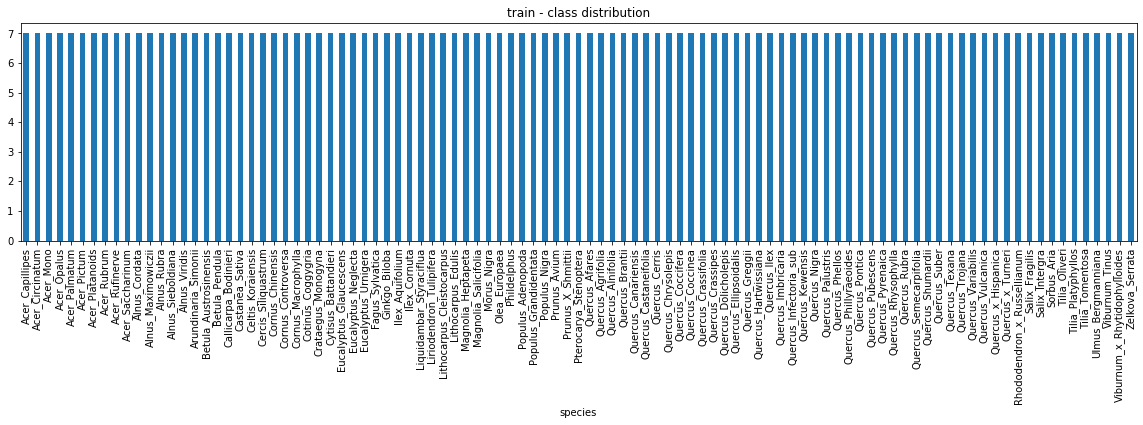

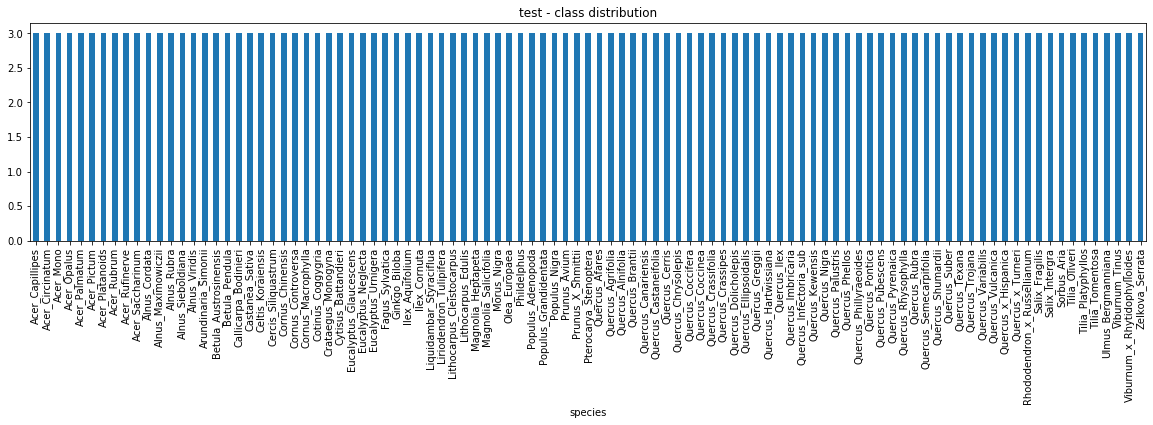

In [12]:
train_features.groupby("species").count().id.plot.bar(figsize=(20,4))
plt.title("train - class distribution")
plt.show()

test_features.groupby("species").count().id.plot.bar(figsize=(20,4))
plt.title("test - class distribution")
plt.show()

In [13]:
num_classes = data.species.value_counts().shape[0]
print("There are {} classes for the classification task.".format(num_classes))

There are 99 classes for the classification task.


In [14]:
species = data.species.value_counts().index.tolist()
species = {species[i]:i for i in range(len(species))}

In [15]:
set_target = lambda x:species[x]
train_features.loc[:, "target"] = train_features.species.apply(set_target).values
test_features.loc[:, "target"] = test_features.species.apply(set_target).values

/home/daielchom/Documents/envs/maestria/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/daielchom/Documents/envs/maestria/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
_ = train_features.pop("species")
_ = test_features.pop("species")

### split shapes

In [55]:
train_shapes = shapes[shapes.id.isin(train_ids)]
test_shapes = shapes[shapes.id.isin(test_ids)]

### split center images

In [18]:
train_center_images = {i:center_images[i] for i in center_images if i in train_ids}
test_center_images =  {i:center_images[i] for i in center_images if i in test_ids}

In [20]:
len(train_center_images), len(test_center_images)

(693, 297)

### split resize images

In [40]:
train_resize_images = {i:resize_images[i] for i in resize_images if i in train_ids}
test_resize_images =  {i:resize_images[i] for i in resize_images if i in test_ids}

In [41]:
len(train_resize_images), len(test_resize_images)

(693, 297)

# Train data

In [57]:
train_features.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,target
1,2,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000000,0.000000,0.000977,0.023438,0.0,0.000000,0.000977,0.039062,0.022461,94
4,6,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.000000,0.021484,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.031250,80
5,8,0.070312,0.093750,0.033203,0.001953,0.000000,0.152340,0.007812,0.0,0.003906,...,0.000000,0.041992,0.000000,0.005859,0.0,0.000000,0.000000,0.001953,0.013672,3
6,10,0.021484,0.031250,0.017578,0.009766,0.001953,0.042969,0.039062,0.0,0.003906,...,0.000000,0.040039,0.000000,0.009766,0.0,0.000000,0.000000,0.039062,0.003906,18
7,11,0.000000,0.000000,0.037109,0.050781,0.003906,0.000000,0.003906,0.0,0.048828,...,0.025391,0.009766,0.002930,0.021484,0.0,0.037109,0.006836,0.002930,0.036133,58


In [58]:
train_shapes.head()

,id,image_height,image_width
1,2,251,667
4,6,331,771
5,8,449,825
6,10,363,858
7,11,766,938


In [66]:
idx = random.randint(0, 600)
tr_idx = train_ids[idx]

Text(0.5, 1.0, 'Train resize image sample\nshape: (128, 128)')

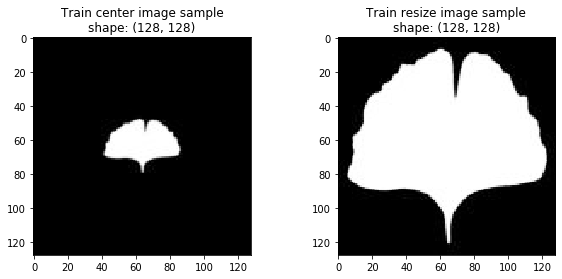

In [69]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(train_center_images[tr_idx], cmap="Greys_r")
plt.title("Train center image sample\nshape: {}".format(train_center_images[tr_idx].shape))

plt.subplot(122)
plt.imshow(train_resize_images[tr_idx], cmap="Greys_r")
plt.title("Train resize image sample\nshape: {}".format(train_resize_images[tr_idx].shape))

In [85]:
t1 = train_features.id.values
t2 = train_shapes.id.values
t3 = np.array(list(train_center_images.keys()))
t4 = np.array(list(train_resize_images.keys()))

In [90]:
print((t1== t2).mean())
print((t2==t3).mean())
print((t3==t4).mean())

1.0
1.0
1.0


# Test data

In [94]:
test_features.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,target
0,1,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.000000,0.002930,0.002930,0.035156,0.00000,0.0,0.004883,0.000000,0.025391,35
2,3,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.000000,0.005859,0.000977,0.007812,0.00000,0.0,0.000000,0.020508,0.002930,4
3,5,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000977,0.000000,0.000000,0.020508,0.00000,0.0,0.017578,0.000000,0.047852,59
9,15,0.000000,0.000000,0.009766,0.037109,0.072266,0.000000,0.000000,0.0,0.007812,...,0.000000,0.000000,0.070312,0.013672,0.19238,0.0,0.074219,0.000000,0.000000,96
12,20,0.015625,0.011719,0.041016,0.003906,0.023438,0.015625,0.019531,0.0,0.009766,...,0.000000,0.086914,0.000000,0.013672,0.00000,0.0,0.000000,0.011719,0.002930,74


In [95]:
test_shapes.head()

,id,image_height,image_width
0,1,467,526
2,3,456,691
3,5,466,505
9,15,275,1101
12,20,355,734


In [70]:
idx = random.randint(0, 290)
ts_idx = test_ids[idx]

Text(0.5, 1.0, 'Test resize image\nshape: (128, 128)')

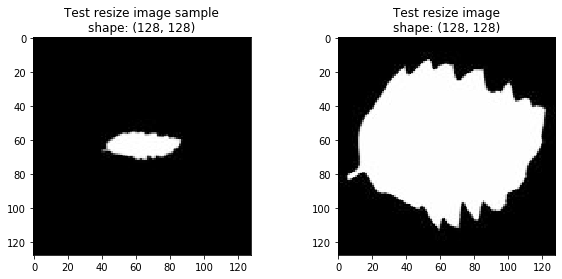

In [72]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(test_center_images[ts_idx], cmap="Greys_r")
plt.title("Test resize image sample\nshape: {}".format(test_center_images[ts_idx].shape))

plt.subplot(122)
plt.imshow(test_resize_images[ts_idx], cmap="Greys_r")
plt.title("Test resize image\nshape: {}".format(test_resize_images[ts_idx].shape))

In [96]:
t1 = test_features.id.values
t2 = test_shapes.id.values
t3 = np.array(list(test_center_images.keys()))
t4 = np.array(list(test_resize_images.keys()))

In [97]:
print((t1== t2).mean())
print((t2==t3).mean())
print((t3==t4).mean())

1.0
1.0
1.0
